# Do-It-Yourself

In this section, we are going to try 

In [100]:
import geopandas as gpd
import contextily as cx
from pysal.lib import weights
from pysal.lib import examples
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [22]:
gdf = gpd.read_file("./resources_0cc3a7a5-6066-48ba-a937-3536d704a8aa_green-space-2016.geojson")

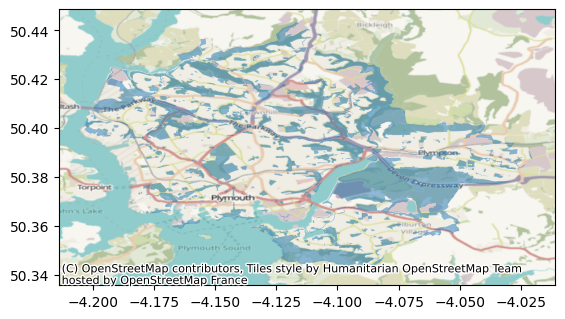

In [23]:
f, ax = plt.subplots(1)
gdf.plot(ax=ax, alpha=0.5)
cx.add_basemap(ax=ax, crs=gdf.crs)

(diy_E:tracts)=
## Task I: NYC tracts

In this task we will explore contiguity weights.To do it, we will load Census tracts for New York City. Census tracts are the geography the US Census Burearu uses for areas around 4,000 people. We will use a dataset prepared as part of the [PySAL examples](https://pysal.org/libpysal/tutorial.html?highlight=examples#example-datasets). Geographically, this is a set of polygons that cover all the area of the city of New York.

A bit of info on the dataset:

In [24]:
examples.explain("NYC Socio-Demographics")

To check out the location of the files that make up the dataset, we can load it with `load_example` and inspect with `get_file_list`:

In [25]:
# Load example (this automatically downloads if not available)
nyc_data = examples.load_example("NYC Socio-Demographics")
# Print the paths to all the files in the dataset
nyc_data.get_file_list()

['/home/tristannew/.local/share/pysal/NYC_Socio-Demographics/__MACOSX/._NYC_Tract_ACS2008_12.shx',
 '/home/tristannew/.local/share/pysal/NYC_Socio-Demographics/__MACOSX/._NYC_Tract_ACS2008_12.dbf',
 '/home/tristannew/.local/share/pysal/NYC_Socio-Demographics/__MACOSX/._NYC_Tract_ACS2008_12.shp',
 '/home/tristannew/.local/share/pysal/NYC_Socio-Demographics/__MACOSX/._NYC_Tract_ACS2008_12.prj',
 '/home/tristannew/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.dbf',
 '/home/tristannew/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.shx',
 '/home/tristannew/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.shp',
 '/home/tristannew/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.prj']

And let's read the shapefile:

In [26]:
nyc_data.get_path("NYC_Tract_ACS2008_12.prj")

'/home/tristannew/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.prj'

<Axes: >

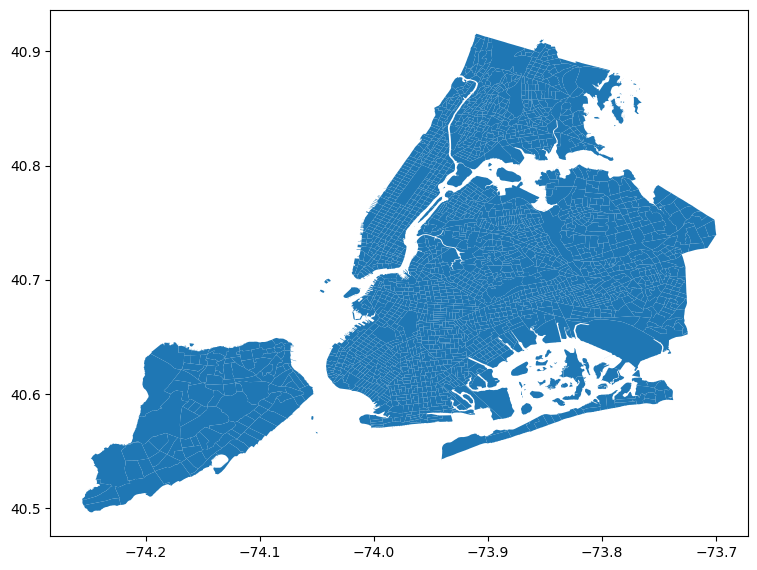

In [27]:
nyc = gpd.read_file(nyc_data.get_path("NYC_Tract_ACS2008_12.shp"))
nyc.plot(figsize=(9, 9))

Now with the `nyc` object ready to go, here a few tasks for you to complete:

- Create a contiguity matrix using the queen criterion
- Let's focus on [Central Park](https://en.wikipedia.org/wiki/Central_Park). The corresponding polygon is ID `142`. *How many neighbors does it have?*
- Try to reproduce the {ref}`zoom plot in the previous section<lab_E:queen_zoom>`.
- Create a block spatial weights matrix where every tract is connected to other tracts in the same borough. For that, use the `borocode` column of the `nyc` table.
- Compare the number of neighbors by tract for the two weights matrices, *which one has more? why?*

### Task 1 Answers

##### Queen Contiguity Matrix

In [28]:
w_queen = weights.Queen.from_dataframe(nyc)
w_queen.remap_ids(nyc.index)

/tmp/ipykernel_22237/3561227766.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_queen = weights.Queen.from_dataframe(nyc)
/home/tristannew/personal_code/gds_course/.venv/lib/python3.10/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 3 islands with ids: 0, 626, 2165.
  warnings.warn(message)


<Axes: >

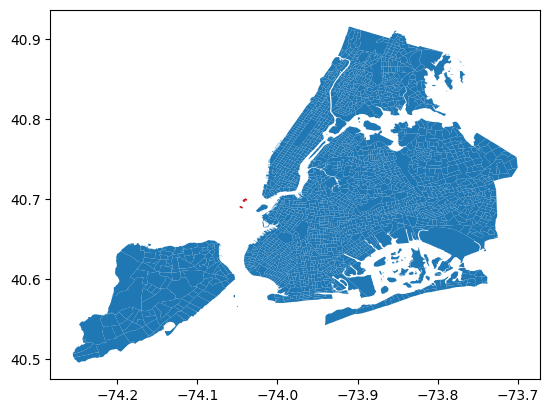

In [29]:
f, ax = plt.subplots(1)
nyc.plot(ax=ax)
nyc.loc[[0],'geometry'].plot(ax=ax, facecolor='red')

##### Central Park Neighbors

In [30]:
# Number of central park neighbors
len(w_queen.neighbors[142])

30

##### Zoom of Central Park

In [31]:
nyc.crs = 'epsg:4326'

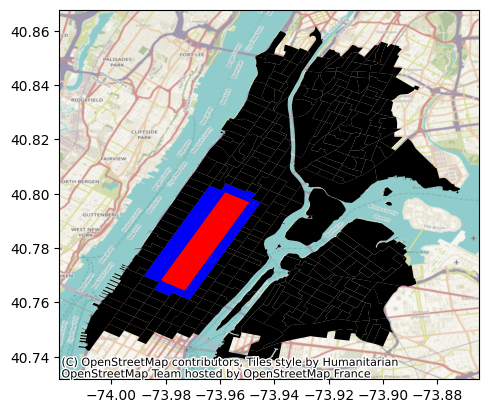

In [32]:
f, ax = plt.subplots(1)

nyc_subset = nyc.cx[-74.05:-73.9, 40.75:40.85]

nyc_subset.plot(ax=ax, color='black')

focus = nyc.loc[[142], 'geometry']
focus.plot(facecolor='red', ax=ax, linewidth=0)

focus_neighbors = nyc.loc[w_queen.neighbors[142], 'geometry']
focus_neighbors.plot(facecolor='blue', ax=ax, linewidth=0)

cx.add_basemap(ax=ax, crs=nyc.crs)

##### `borocode` block spatial weights.

In [33]:
w_block = weights.block_weights(nyc['borocode'])
w_block.remap_ids(nyc.index)

/home/tristannew/personal_code/gds_course/.venv/lib/python3.10/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


##### Compare the number of neighbors by tract for the two weights matrices, *which one has more? why?*

In [34]:
print(f"Queen: {w_queen.mean_neighbors}")
print(f"Block: {w_block.mean_neighbors}")

Queen: 6.186518928901201
Block: 568.7183748845798


(diy_E:jp_cities)=
## Task II: Japanese cities

In this task, you will be generating spatial weights matrices based on distance. We will test your skills on this using a [dataset](http://www.oecd.org/cfe/regionaldevelopment/functional-urban-areas.htm) of Japanese urban areas provided by [OECD](http://www.oecd.org). Let's get it ready for you to work on it directly.

```{margin}
If you are interested in the original methodology, you can check out in {cite}`moreno2020metropolitan`
```

The data is available over the web on [this address](https://www.oecd.org/cfe/regionaldevelopment/JPN.zip) but it is not accessible programmatically. For that reason, we have cached it on the `data` folder, and we can read it directly from there into a `GeoDataFrame`:

In [35]:
jp_cities = gpd.read_file('../data/Japan.zip')
jp_cities.head()

,fuacode_si,fuaname,fuaname_en,class_code,iso3,name,geometry
0,JPN19,Kagoshima,Kagoshima,3.0,JPN,Japan,"MULTIPOLYGON Z (((130.67888 31.62931 0.00000, ..."
1,JPN20,Himeji,Himeji,3.0,JPN,Japan,"MULTIPOLYGON Z (((134.51537 34.65958 0.00000, ..."
2,JPN50,Hitachi,Hitachi,3.0,JPN,Japan,"POLYGON Z ((140.58715 36.94447 0.00000, 140.61..."
3,JPN08,Hiroshima,Hiroshima,3.0,JPN,Japan,"MULTIPOLYGON Z (((132.29648 34.19932 0.00000, ..."
4,JPN03,Toyota,Toyota,4.0,JPN,Japan,"MULTIPOLYGON Z (((137.04096 34.73242 0.00000, ..."


If we make a quick plot, we can see these are polygons covering the part of the Japanese geography that is considered urban by their analysis:

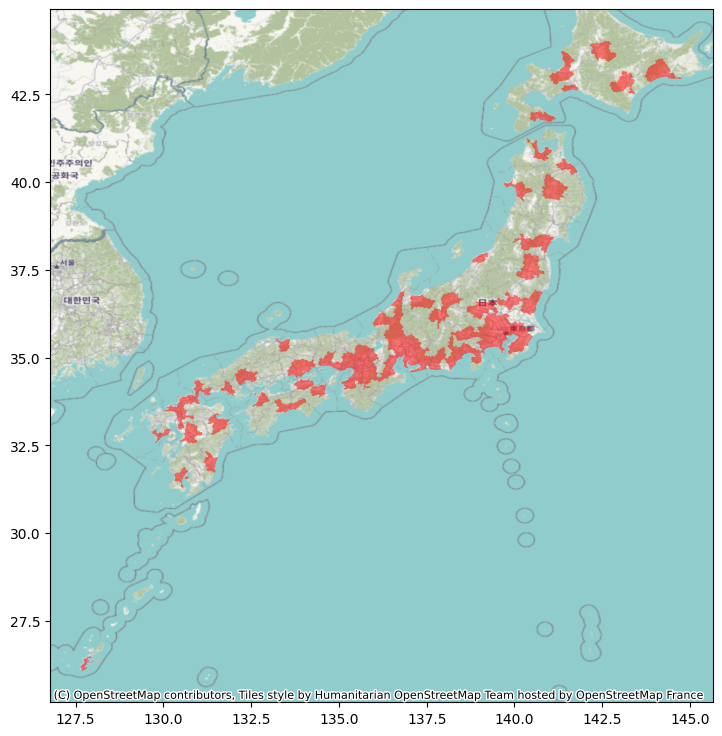

In [36]:
ax = jp_cities.plot(color="red", alpha=0.5, figsize=(9, 9))
cx.add_basemap(ax, crs=jp_cities.crs)

For this example, we need two transformations: lon/lat coordinates to a geographical projection, and polygons to points. To calculate distances effectively, we need to ensure the coordinates of our geographic data are expressed in metres (or a similar measurement unit). The original dataset is expressed in lon/lat degrees:

In [37]:
jp_cities.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We can use the Japan Plane Rectangular CS XVII system ([`EPSG:2459`](http://epsg.io/2459)), which is expressed in metres:

In [38]:
jp = jp_cities.to_crs(epsg=2459)

So the resulting table is in metres:

In [39]:
jp.crs

<Projected CRS: EPSG:2459>
Name: JGD2000 / Japan Plane Rectangular CS XVII
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Japan - onshore Okinawa-ken east of 130°E.
- bounds: (131.12, 24.4, 131.38, 26.01)
Coordinate Operation:
- name: Japan Plane Rectangular CS zone XVII
- method: Transverse Mercator
Datum: Japanese Geodetic Datum 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Now, distances are easier to calculate between points than between polygons. Hence, we will convert the urban areas into their centroids:

In [40]:
jp.geometry = jp.geometry.centroid

So the result is a seet of points expressed in metres:

<Axes: >

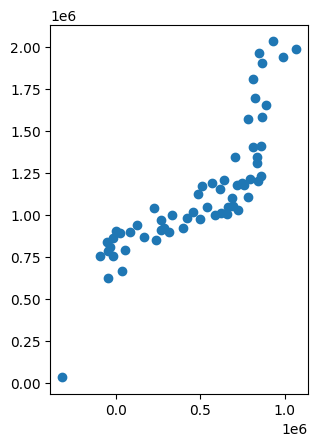

In [41]:
jp.plot()

With these at hand, tackle the following challenges:

- Generate a spatial weights matrix with five nearest neighbors
````{margin}
```{tip}
Remember the dataset is expressed in metres, not Kilometres!
```
````
- Generate a spatial weights matrix with a 100km distance band
- Compare the two in terms of average number of neighbors. *What are the main differences you can spot? In which cases do you think one criterion would be preferable over the other?*
```{warning}
The final task below is a bit more involved, so do not despair if you cannot get it to work completely!
```

````{margin}
```{tip}
Be careful with the projections you are using and make sure to plot every dataset in a figure in the same projection!
```
````
Focus on Tokyo (find the row in the table through a query search as we saw when considering {ref}`lab_B:index_queries`) and the 100km spatial weights generated above. Try to create a figure similar to [the one in the lecture](https://darribas.org/gds_course/content/slides/block_E_ii.html). Here's a recipe:
1. Generate a buffer of 100Km around the Tokyo centroid
1. Start the plot with the Tokyo urban area polygon (`jp_cities`) in one color (e.g. red)
1. Add its neighbors in, say blue
1. Add their centroids in a third different color
1. Layer on top the buffer, making sure only the edge is colored
1. [Optional] Add a basemap

If all goes well, your figure should look, more or less, like:

##### TASK II

##### Spatial weights with 5 nearest neighbors

In [48]:
pts = pd.DataFrame(
    {"X": jp.geometry.x, "Y": jp.geometry.y}
).values
weights_knn = weights.KNN.from_array(pts, k=5)

##### Spatial weights from distance band

In [49]:
weights_distance_band = weights.DistanceBand.from_array(pts, 100000)

/home/tristannew/personal_code/gds_course/.venv/lib/python3.10/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 4 islands with ids: 14, 17, 30, 54.
  warnings.warn(message)


##### Compare the two

In [50]:
print(f"""
KNN Mean Neighbors: {weights_knn.mean_neighbors}
Distance Band Mean Neighbors: {weights_distance_band.mean_neighbors}
""")


KNN Mean Neighbors: 5.0
Distance Band Mean Neighbors: 3.4098360655737703



Knn obviously has as many neighbors as you have chosen, that is how it is defined. Neighbors is constant distance (and vertices and edges) varies. Conversely, distance band is defined by distance, so distance is constant-ish and neighbors (and vertices and edges) varies. Distance bands would be preferable when distance is an important factor i.e. studies on commuting and how it is affected by distance, or greenspace studies. KNN would be preferable probably when looking at regions individually.

##### Tokyo Plot

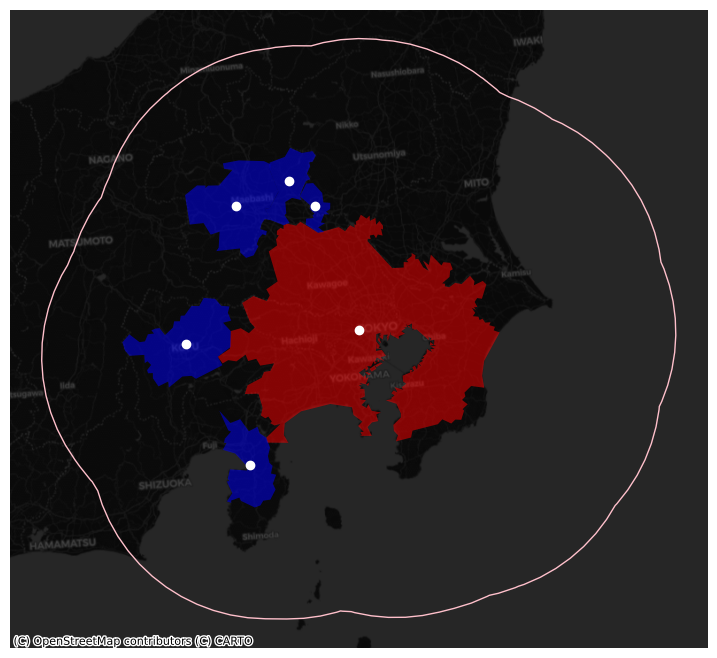

In [91]:
f, ax = plt.subplots(1, figsize=(9,9))

tokyo_idx = jp.query("fuaname == 'Tokyo'").index[0]

focus = jp_cities[jp_cities['fuaname'] == 'Tokyo'].to_crs(epsg=2459)
focus.plot(ax=ax, color='red', alpha=0.5)

dist_neighbors = jp_cities.iloc[weights_distance_band.neighbors[tokyo_idx], :].to_crs(epsg=2459)
dist_neighbors.plot(ax=ax, color='blue', alpha=0.5)

# Good to get cents, but maybe more elegant to go jp_cities.to_crs(jp.crs).loc[[tokyo], :].centroid.plot(ax=ax, color="white")
cents = jp.iloc[weights_distance_band.neighbors[tokyo_idx]+[tokyo_idx], :]
cents.plot(ax=ax, color='white')

buff = focus.buffer(100000)
buff.plot(ax=ax, edgecolor='pink', facecolor='none')

# knn_neighbors = jp_cities.iloc[weights_knn.neighbors[32], :]
# knn_neighbors.plot(ax=ax, color='green')

ax.set_axis_off()

cx.add_basemap(ax=ax, crs=jp.crs, source=cx.providers.CartoDB.DarkMatter)

In [59]:
jp[jp['fuaname'] == 'Tokyo'].index

Index([32], dtype='int64')

/home/tristannew/personal_code/gds_course/.venv/lib/python3.10/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 4 islands with ids: 14, 17, 30, 54.
  warnings.warn(message)


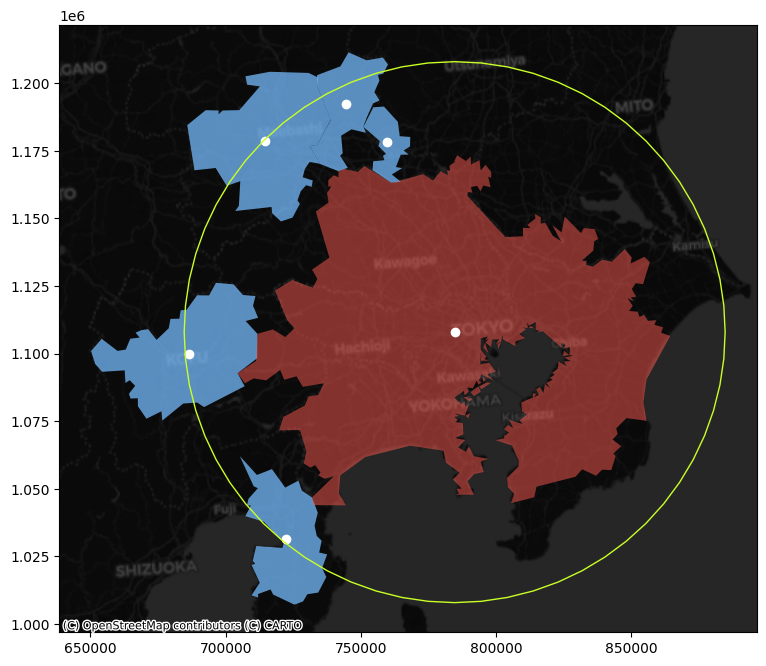

In [85]:
from libpysal import weights
w = weights.DistanceBand.from_dataframe(jp, 100000)
tokyo = jp.query("fuaname == 'Tokyo'").index[0]
buff = jp.loc[[tokyo], :].buffer(100000)
neis_df = jp_cities.loc[w.neighbors[tokyo]].to_crs(jp.crs)

# Plot neighbors
ax = neis_df.plot(color="xkcd:sky blue", alpha=0.75, figsize=(9, 9))
# Plot Tokyo in red
jp_cities.to_crs(jp.crs).loc[[tokyo], :].plot(ax=ax, color="xkcd:coral", alpha=0.5)
# Plot Tokyo centroid in white
jp_cities.to_crs(jp.crs).loc[[tokyo], :].centroid.plot(ax=ax, color="white")
# Plot neighbor centroids in white
neis_df.centroid.plot(ax=ax, color="white")
# Plot buffer in green
buff.plot(ax=ax, facecolor="none", edgecolor="xkcd:green yellow")
# Add basemap
cx.add_basemap(
    ax, 
    crs=jp.crs, 
    source=cx.providers.CartoDB.DarkMatter
)

## Task III: Spatial Lag

```{margin}
Check out the notes on how to read the AHAH dataset on the {ref}`DIY section of block D <diy_D:ahah>` to refresh your mind before starting the task.
```
For this task, we will rely on the AHAH dataset. Create the spatial lag of the overall score, and generate a Moran plot. *Can you tell any overall pattern? What do you think it means?*

#### Task III Answers

In [93]:
lsoas = gpd.read_file("../bD/data/Access_to_Healthy_Assets_and_Hazards_AHAH/Local_Authority_Districts/E08000012/shapefiles/E08000012.shp")
ahah_data = pd.read_csv("../bD/data/Access_to_Healthy_Assets_and_Hazards_AHAH/Local_Authority_Districts/E08000012/tables/E08000012.csv")
ahah = lsoas.join(ahah_data.set_index("lsoa11cd"), on="lsoa11cd")

In [96]:
ahah_weights = weights.Queen.from_dataframe(ahah)

/tmp/ipykernel_22237/1236316129.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  ahah_weights = weights.Queen.from_dataframe(ahah)


In [106]:
ahah_weights.transform = "R"

ahah_no2_score = weights.lag_spatial(ahah_weights, ahah['no2_mean'])

ahah['lag_no2'] = ahah_no2_score

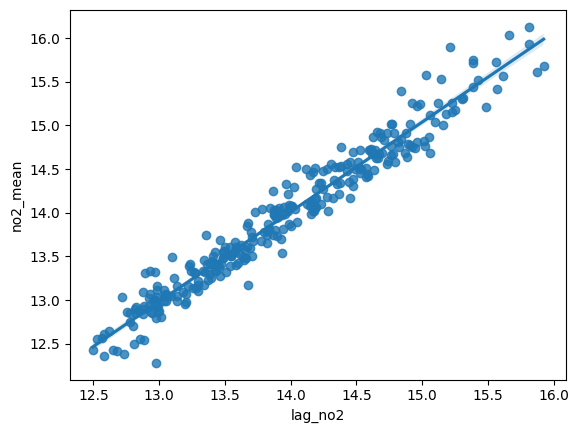

In [107]:
f, ax = plt.subplots(1)

sns.regplot(x='lag_no2', y='no2_mean', data=ahah)

plt.show()

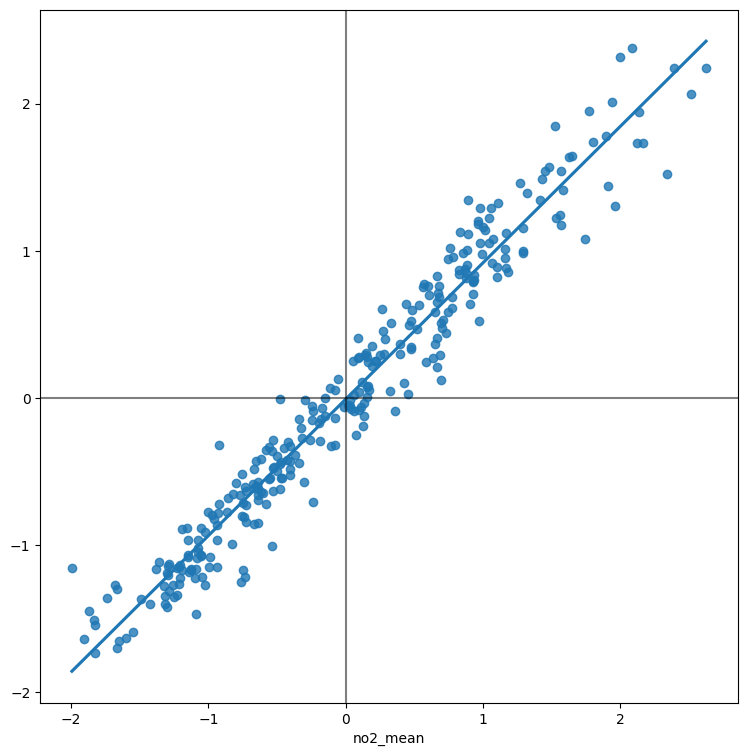

In [109]:
std_no2_mean = (ahah['no2_mean'] - ahah['no2_mean'].mean()) / ahah['no2_mean'].std()

lag_no2 = pd.Series(
    weights.lag_spatial(ahah_weights, std_no2_mean), index=std_no2_mean.index
)

f, ax = plt.subplots(1, figsize=(9, 9))

sns.regplot(x=std_no2_mean, y=lag_no2, ci=None)

plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)

plt.show()